In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

import copy
import argparse

%matplotlib inline

In [2]:
ames_train = pd.read_csv('./datasets/train.csv')
ames_test = pd.read_csv('./datasets/test.csv')
ames_test_1 = pd.read_csv('./datasets/test.csv')
print(ames_train.shape)
print(ames_test.shape)

(2051, 81)
(879, 80)


In [3]:
# ames_train._get_numeric_data

In [4]:
ames_test.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [5]:
tested_col = ['Street',
            'Neighborhood', 
            'Bldg Type', 
            'Overall Qual',
            'Overall Cond', 
            'Year Built', 
            'Year Remod/Add',
            'Roof Matl', 
            'Exterior 1st', 
            'Foundation', 
            'Total Bsmt SF',
            'Heating', 
            'Central Air', 
            '1st Flr SF',
            'Gr Liv Area',
            'Full Bath',
            'TotRms AbvGrd', 
            'Garage Type',
            'Garage Yr Blt']

In [6]:
ames_train.corr()[['SalePrice']].sort_values('SalePrice', ascending=False)

,SalePrice
SalePrice,1.000000
Overall Qual,0.800207
Gr Liv Area,0.697038
Garage Area,0.650270
Garage Cars,0.648220
Total Bsmt SF,0.628925
1st Flr SF,0.618486
Year Built,0.571849
Year Remod/Add,0.550370
Full Bath,0.537969


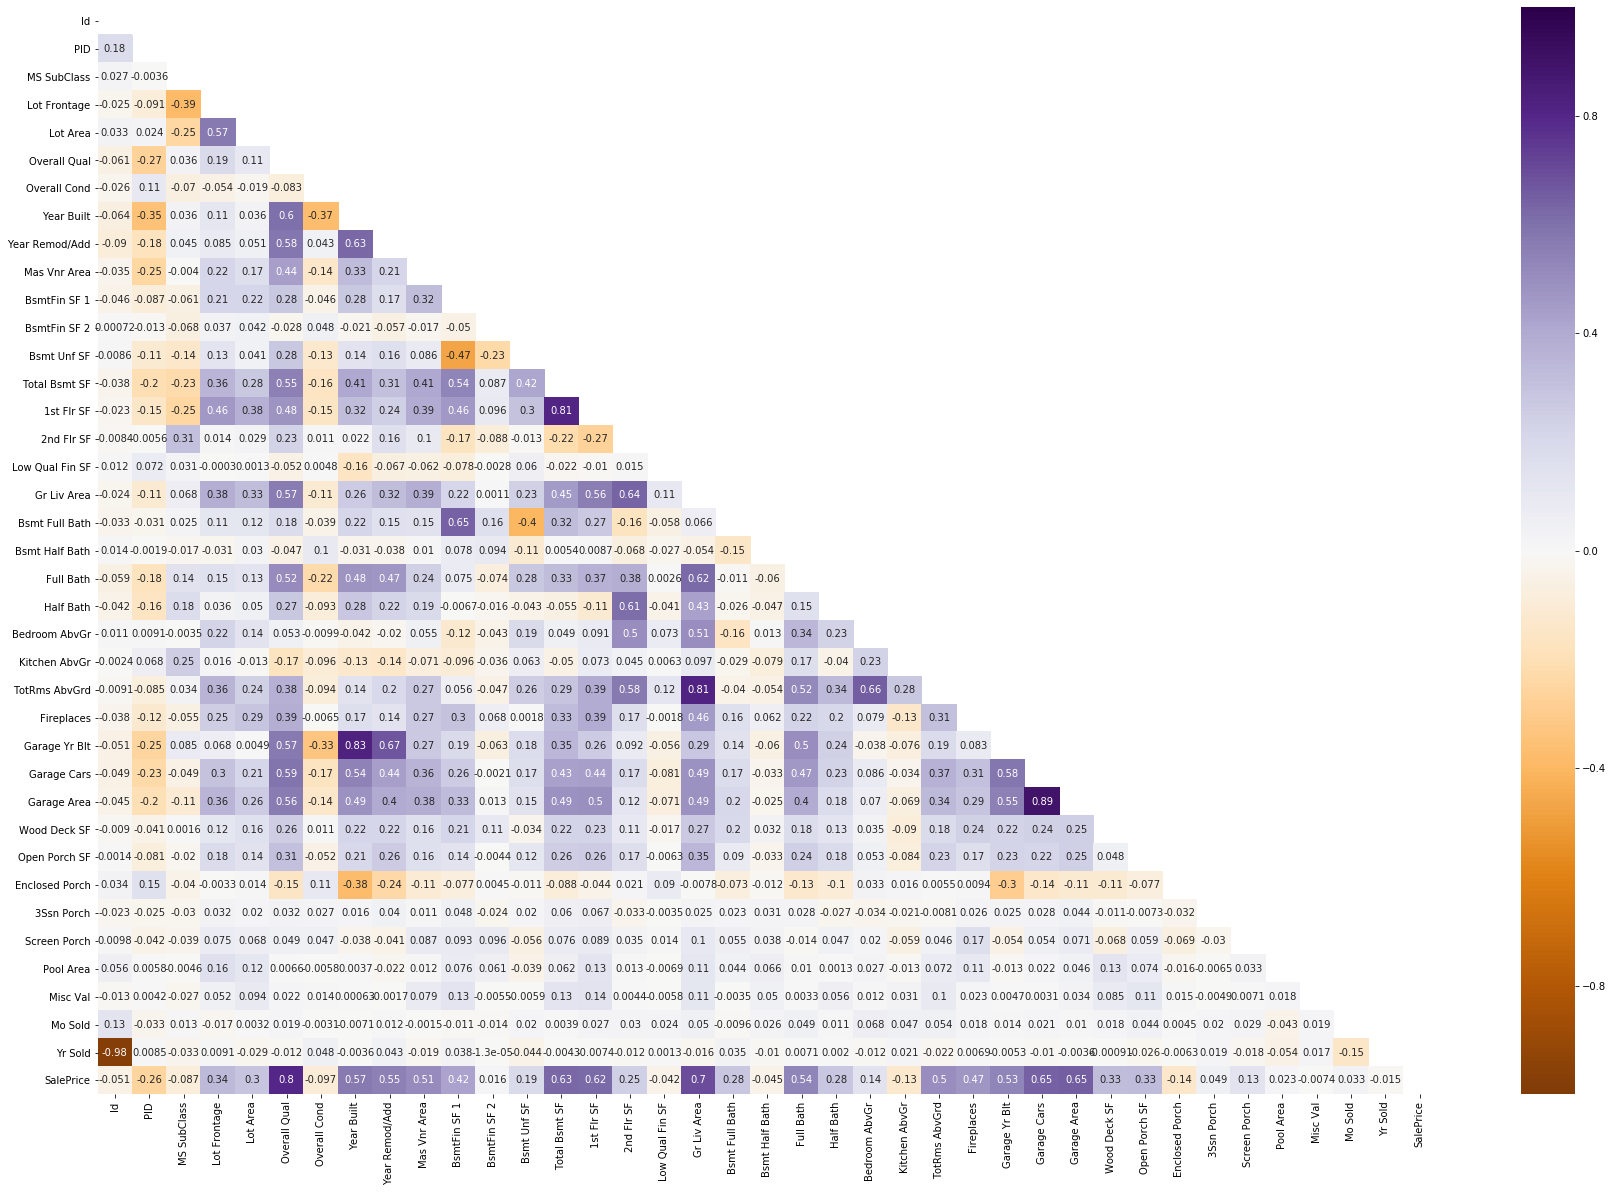

In [7]:
plt.figure(figsize = (30, 20))

mask = np.zeros_like(ames_train.corr())
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(ames_train.corr(), mask=mask, vmin=-1, annot=True, cmap="PuOr");

In [8]:
# # Creating a function that makes a power variable (feature) and puts that feature in a dataframe.
# def new_variable(series_1, series_2, series_name, df):
#     df[series_name] = series_1 * series_2
#     return df

In [9]:
def dropped_cols(df, tested_col):
    dropped_col = []
    for col in df:
        if col not in tested_col:
            dropped_col.append(col)
    return dropped_col  


def dummy_vars_list(df, tested_cols):
    dummy_vars_list = []
    for col in tested_cols:
        if df[col].dtype.name == 'object':
            dummy_vars_list.append(col)
    return dummy_vars_list            
    


def get_dummies(train, test, columns, drop_first=True,
                inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)

    for column in columns:
        train_levels = set(train[column])
        test_levels = set(test[column])
        all_levels = sorted(train_levels.union(test_levels))
        if drop_first:
            all_levels = all_levels[1:]
        for level in all_levels:
            dummy_name = "is_%s" % level
            train[dummy_name] = (train[column] == level)
            test[dummy_name] = (test[column] == level)
            train[dummy_name].apply(int)
            test[dummy_name].apply(int)
    train.drop(columns=columns, inplace=True)
    test.drop(columns=columns, inplace=True)

    # return only necessary if inplace=False
    return (train, test)

def check_compatibility(train, test):
    # assume compatible unless one of these checks fails
    if not (len(train.columns) == len(test.columns)):
        return False
    for column in train.columns:
        if not (column in test.columns):
            return False
    return True


def clean_data(train, test, columns_to_drop,
               columns_for_dummies, remove_na=True,
               drop_first=True, inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
  
    # inplace=True because if user called with inplace=False,
    # we already made a copy and aren't modifying his/her original
    train.drop(columns=columns_to_drop, inplace=True)
    test.drop(columns=columns_to_drop, inplace=True)

    # same reason as above for inplace=True
    if remove_na:
        train.dropna(inplace=True)
        test.dropna(inplace=True)

    (train, test) = get_dummies(train, test,
                                columns=columns_for_dummies,
                                drop_first=drop_first,
                                inplace=inplace)

    return (train, test)


###################

def patrick_clean_data(train_df, test_df, variables, remove_na=True, drop_first=True, inplace=False):
    columns_to_drop = dropped_cols(test_df, variables)
    dummy_columns = dummy_vars_list(test_df, variables)
    new_train, new_test = clean_data(train_df, test_df, 
                                     columns_to_drop, 
                                     dummy_columns, 
                                     remove_na=remove_na, 
                                     drop_first=drop_first, 
                                     inplace=inplace)
    y_col_name = []
    for col in new_train.columns:
        if col not in new_test.columns:
            y = new_train[col]
            y_col_name = col
    new_train = new_train.drop(y_col_name, axis=1)
    
    assert check_compatibility(new_train, new_test)
    
#     for column in new_test.columns: # Turn this on if I want to see what columns were made
#         print(column)

    return new_train, new_test, y

In [10]:
new_train, new_test, y = patrick_clean_data(ames_train, ames_test, tested_col,)
print(new_test.shape)
print(new_train.shape)


(834, 76)
(1936, 76)


In [11]:
def metrics_summary(X, y, cv, k):
    model = LinearRegression()
    model.fit(X,y)
    model_p = model.predict(X)
    resids = y - model_p
    rss = (resids ** 2).sum()
    r_squared = (metrics.r2_score(y, model_p))
    adj_r2 = 1 - (1-r_squared)*((len(y)-1)/(len(y)-X.shape[k]-1))
    cvs = cross_val_score(model, X, y, cv=cv).mean()

    print(f'RSS (Residual Sum of Squares) : {(rss)}')
    print(f'MAE (Mean Absolute Error) : {(metrics.mean_absolute_error(y, model_p))}') 
    print(f'MSE (Mean Square Error) : {(metrics.mean_squared_error(y, model_p))}')
    print(f'Root MSE (Root Meen Square Error) : {(np.sqrt(rss / len(model_p)))}')
    print(f'R\u00b2 : {(r_squared)}')
    print(f'Adjusted R\u00b2 : {(adj_r2)}')
    print(f'CVS (Cross Value Score) : {(cvs)}')


In [12]:
metrics_summary(new_train, y, 5, 1)

RSS (Residual Sum of Squares) : 1712393151128.774
MAE (Mean Absolute Error) : 19387.001057664882
MSE (Mean Square Error) : 884500594.5913088
Root MSE (Root Meen Square Error) : 29740.554712232737
R² : 0.8579038915556412
Adjusted R² : 0.8520946907800784
CVS (Cross Value Score) : 0.8257034397464853
